In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense, Activation, Conv2D, Input, Lambda, Flatten, Permute
from keras.optimizers import Adam, SGD, RMSprop
import keras.backend as K
from tqdm import tqdm
import cv2

Using TensorFlow backend.


# Agent

In [2]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class Agent():
    
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()
                   
    
        self.current_state = []
            
        
    def build_model(self):
        
        input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
        model = Sequential()

        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
        model.add(Conv2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        print(model.summary())
        return model
    
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
        
    
    def next_action(self, state):
        actions = self.model.predict(state)[0]
        return np.argmax(actions)
     

In [3]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class Agent():
    
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()
                   
    
        self.current_state = []
            
        
    def build_model(self):
        
        input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
        model = Sequential()

        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
        model.add(Conv2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(6))
        model.add(Activation('linear'))
        print(model.summary())
        #model.summary()
        
        model.compile(Adam(lr=.00025), loss='mae')
        return model
    
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
        
    
    def next_action(self, state):
        actions = self.model.predict(state)[0]
        return np.argmax(actions)
     

# Env

In [4]:
env = gym.make('SpaceInvaders-v4')
np.random.seed(123)
env.seed(123)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [5]:
agent = Agent(state_size, action_size)
agent.model.load_weights("../Atari_RL/DQN/weights/dqn_SpaceInvaders-v4_weights_10000000.h5f")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

# Jupyter Render

In [6]:
actions = env.unwrapped.get_action_meanings()

In [7]:
def get_heat_map_gradient(iterate, x, state):
    
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    a = np.max(conv_layer_output_value)
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (160, 210))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    #superimposed_img = heatmap * a * 20 + state
    superimposed_img = heatmap * 0.4 + state
    return superimposed_img / 255

In [17]:
def get_heat_map_activation(iterate, x, state):
    
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #heatmap = np.maximum(heatmap, 0)
    #heatmap = heatmap / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (160, 210))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    superimposed_img = heatmap * 0.4 + state
    return superimposed_img/255

In [9]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

def distant_render(env, agent, state_size, nb_steps=1000):
    
    model = agent.model
    iterates = []
    for i in range(env.action_space.n):
        predictiont_output = model.output[:, i]
        last_conv_layer = model.get_layer('conv2d_3')
        grads = K.gradients(predictiont_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterates.append(K.function([model.input], [pooled_grads, last_conv_layer.output[0]]))
    
    state_img = env.reset()
    previous_state = state_img
    img = plt.imshow(state_img)
    state = agent.process_observation(state_img)
    current_state = np.array([state, state, state, state])
    done = False
     # only call this once
    for i in range(nb_steps):
              
        x = agent.process_state_batch(current_state)
        x = np.expand_dims(x, axis=0)
        action = agent.next_action(x)
        
        img.set_data(state_img) # just update the data
        plt.title(actions[action])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        next_state, reward, done, _ = env.step(action)
        state_img = get_heat_map_gradient(iterates[action], x, previous_state)
        previous_state = next_state
        next_state = agent.process_observation(next_state)
        current_state = np.insert(current_state[1:,:,:], 3, next_state, axis=0)
        if done:
            break
    
    return state_img, previous_state

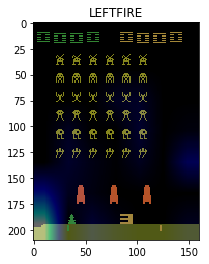

In [15]:
img, previous = distant_render(env, agent, state_size, 10)

# Movie

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

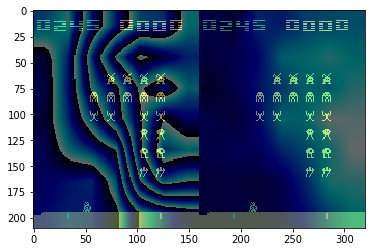

In [18]:
import warnings
warnings.filterwarnings('ignore')

matplotlib.use("Agg")
env.seed(123)
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

model = agent.model
iterates = []
for i in range(env.action_space.n):
    predictiont_output = model.output[:, i]
    last_conv_layer = model.get_layer('conv2d_3')
    grads = K.gradients(predictiont_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterates.append(K.function([model.input], [pooled_grads, last_conv_layer.output[0]]))

fig = plt.figure()
state_frame = env.reset()
state = agent.process_observation(state_frame)
current_state = np.array([state, state, state, state])
l = plt.imshow(np.concatenate((state_frame, state_frame), axis=1))
done = False
with writer.saving(fig, "Videos\DQN_space_invaders.mp4", 100):
    while not done:
        x = agent.process_state_batch(current_state)
        x = np.expand_dims(x, axis=0)
        action = agent.next_action(x)
        next_state, reward, done, _ = env.step(action)
        frame1 = get_heat_map_activation(iterates[action], x, state_frame)
        frame2 = get_heat_map_gradient(iterates[action], x, state_frame)
        frame = np.concatenate((frame1, frame2), axis=1)
        state_frame = next_state
        next_state = agent.process_observation(next_state)
        current_state = np.insert(current_state[1:,:,:], 3, next_state, axis=0)
        l.set_data(frame)
        writer.grab_frame()